## Helper Functions

In [125]:
def hex_to_geoboundary(value):
    if isinstance(value,str):
        return shapely.geometry.Polygon(h3.h3_to_geo_boundary(value, True))
    else:
        return np.nan

In [126]:
#Helper function to find a spot in a matrix
def findSpot(matrix,plot):
    maxrows = matrix.shape[0] #amount of rows
    maxcols = matrix.shape[1] #amount of cols
    
    rowc = -1
    for row in matrix:
        rowc = rowc+1
        itemc = -1
        for item in row:
            itemc = itemc + 1
            if (rowc + plot[0] > maxrows) or (itemc + plot[1] > maxcols):
                continue
            if item == 0: #find potential spot
                space = True
                for i in range(rowc,rowc+plot[0]):#find out whether it fits
                    for u in range(itemc,plot[1]):
                        if matrix[i,u] == 1: 
                            space = False
                if space:
                    return((rowc,itemc))
    return False


In [127]:
# Create Subplot, return figure and array of axes
def create_subplot_fig(title = "Unnamed Plot",figsize=(12,8),x=1,y=1,names=["1","2"]):
    
    fig,axes = plt.subplots(nrows=y,ncols=x,figsize=figsize)
    fig = style_fig(fig,title=title)

    if x*y == 1:
        axes = np.array([axes])
    
    if x>1 and y>1:
        axes = axes.flatten()

    for ax in axes:
        ax.ticklabel_format(axis='both', style='plain')

    # case more than one
    if len(names) == x*y:
        i = 0
        for ax in axes:
            ax.set_title(names[i],fontname="Arial")
            i = i+1                 
    return fig,axes

#Create a gridplot that automatically arranges plots from left to right and horizontally
def create_gridplot(title="Unnamed Plot",figsize=(12,8),gridsize=(6,3),plotsizes=[(3,2),(1,1),(1,2)],direction="h",names=[]):
    
    fig  = create_fig(title=title,figsize=figsize)
    fig=style_fig(fig,title=title)
    
    axes = []
    taken = np.zeros(gridsize)
    
    if direction == "h":
        for plot in plotsizes:
            spot = findSpot(taken,plot)
            if spot:
                for i in range(spot[0],spot[0]+plot[0]):
                    for u in range(spot[1],spot[1]+plot[1]):
                        taken[i,u] = 1
                axes.append(plt.subplot2grid(gridsize, spot, colspan=plot[1], rowspan=plot[0]))
            else: 
                print("no spot found")
    else: 
        print("Vertical Option is not implemented yet")

    for ax in axes:
        ax.ticklabel_format(axis='both', style='plain')
        
    if len(axes) == len(names):
        i = 0
        for ax in axes:
            ax.set_title(names[i])
            i=i+1
    return fig,axes



# Give Figure a styling
def style_fig(fig,title="Unnamed Plot"):
    fig.suptitle(title, x=0.5, y=0.98, color='black',size=15,fontname="Arial")
    fig.tight_layout()
    return fig

# create figure
def create_fig(title = "Unnamed Plot",figsize=(12,8)):
    fig = plt.figure(figsize = figsize)
    fig = style_fig(fig,title)
    return fig

# Descriptive Analysis

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
from shapely import wkt
import h3
from datetime import date
import pyarrow.parquet as pq
import pyarrow as pa
from fastparquet import write
import parquet
import contextily as ctx
import seaborn as sns

In [129]:
df = pd.read_parquet("../data/df_cleaned_24_06_2021.parquet")
df = df.iloc[0:100000]

In [130]:
df["PU_Centroid"] = gpd.points_from_xy(df["Pickup Centroid Latitude"], df["Pickup Centroid Latitude"])
df["DO_Centroid"] = gpd.points_from_xy(df["Dropoff Centroid Latitude"], df["Dropoff Centroid Latitude"])                                                   
#df = df.drop(columns = ["Pickup Centroid Latitude","Pickup Centroid Longitude","Dropoff Centroid Latitude","Dropoff Centroid Longitude"])
df["Trip Start Timestamp"] = pd.to_datetime(df["Trip Start Timestamp"],format = '%m/%d/%Y %I:%M:%S %p')
df["Trip End Timestamp"] = pd.to_datetime(df["Trip End Timestamp"],format = '%m/%d/%Y %I:%M:%S %p')
df.head()

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,PU_HOUR,DO_MONTH_NAME,DO_WEEKDAY_NAME,DO_MONTH,DO_WEEKDAY,DO_HOUR,PU_DATE,DO_DATE,PU_Centroid,DO_Centroid
489487,5487de4e97b71188efadf95669f532a5ccb08843,56f2fce86600dd132681be1323fe78ce26e60f2fffe4b3...,2017-01-09 11:45:00,2017-01-09 12:00:00,480.0,0.10,NaN,NaN,8.0,7.0,...,12,January,Monday,1,0,12,2017-01-09,2017-01-09,POINT (41.89960 41.89960),POINT (41.92269 41.92269)
16284335,491aabe21dbd65e2fa8efca4cdf7d6bf40f45b89,edcd6d939a065b4d0028d5219351a593d77b1b17637db3...,2017-08-17 14:30:00,2017-08-17 14:30:00,240.0,0.90,1.703132e+10,1.703108e+10,32.0,8.0,...,15,August,Thursday,8,3,15,2017-08-17,2017-08-17,POINT (41.87741 41.87741),POINT (41.89092 41.89092)
4052837,522fe170918a41a9eacb8c665b5a699be9db33c8,fbdfc1bdf8477e6043d2012f98283fdbc6212192a065ab...,2017-03-03 07:30:00,2017-03-03 07:45:00,360.0,0.20,NaN,NaN,6.0,8.0,...,8,March,Friday,3,4,8,2017-03-03,2017-03-03,POINT (41.94423 41.94423),POINT (41.89960 41.89960)
14574858,0fc17e1ac2fbdbe5ce772521e712341bb5b19d64,e428b282d868d83ee36a566f79e7e8926c9c3c631809cc...,2017-07-23 10:30:00,2017-07-23 10:30:00,401.0,1.19,1.703132e+10,1.703108e+10,32.0,8.0,...,11,July,Sunday,7,6,11,2017-07-23,2017-07-23,POINT (41.88499 41.88499),POINT (41.89197 41.89197)
3642582,53278beb03b150357771f184b6b0787eec16c095,5e3077a68e0439a1168a98d848e9ae3fd8c74f61bc4323...,2017-02-25 10:00:00,2017-02-25 10:30:00,1496.0,17.50,1.703198e+10,1.703108e+10,76.0,8.0,...,11,February,Saturday,2,5,11,2017-02-25,2017-02-25,POINT (41.97907 41.97907),POINT (41.89092 41.89092)


In [131]:
df["PU_isWorkday"] = df["PU_WEEKDAY"] < 6
df["DO_isWorkday"] = df["DO_WEEKDAY"] < 6

In [132]:
illinois_holidays = pd.read_csv("../data/holidays_illinois.csv",sep=";")
illinois_holidays["date"] = pd.to_datetime(illinois_holidays["date"],format = '%d.%m.%Y').dt.date
illinois_holidays["free_day"] = True
illinois_holidays

,Holiday,date,free_day
0,New Year's Day,2017-01-01,True
1,Martin Luther King Day,2017-01-18,True
2,Lincoln's Birthday,2017-02-12,True
3,Washington's Birthday,2017-02-15,True
4,Memorial Day,2017-05-31,True
5,Juneteenth Day,2017-06-18,True
6,Independence Day,2017-07-05,True
7,Labor Day,2017-09-06,True
8,Columbus Day,2017-10-11,True
9,Veterans' Day,2017-11-11,True


In [133]:
hol=illinois_holidays[["date","free_day"]]
hol1=hol.copy()
hol2=hol.copy()
hol1.columns=["PU_hol_date","PU_free"]
hol2.columns=["DO_hol_date","DO_free"]
df = pd.merge(df,hol1,how="left",left_on="PU_DATE",right_on="PU_hol_date")
df = pd.merge(df,hol2,how="left",left_on="DO_DATE",right_on="DO_hol_date")
df["PU_isWorkday2"] = df["PU_isWorkday"] | df["PU_free"]
df

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,DO_DATE,PU_Centroid,DO_Centroid,PU_isWorkday,DO_isWorkday,PU_hol_date,PU_free,DO_hol_date,DO_free,PU_isWorkday2
0,5487de4e97b71188efadf95669f532a5ccb08843,56f2fce86600dd132681be1323fe78ce26e60f2fffe4b3...,2017-01-09 11:45:00,2017-01-09 12:00:00,480.0,0.10,NaN,NaN,8.0,7.0,...,2017-01-09,POINT (41.89960 41.89960),POINT (41.92269 41.92269),True,True,NaN,NaN,NaN,NaN,True
1,491aabe21dbd65e2fa8efca4cdf7d6bf40f45b89,edcd6d939a065b4d0028d5219351a593d77b1b17637db3...,2017-08-17 14:30:00,2017-08-17 14:30:00,240.0,0.90,1.703132e+10,1.703108e+10,32.0,8.0,...,2017-08-17,POINT (41.87741 41.87741),POINT (41.89092 41.89092),True,True,NaN,NaN,NaN,NaN,True
2,522fe170918a41a9eacb8c665b5a699be9db33c8,fbdfc1bdf8477e6043d2012f98283fdbc6212192a065ab...,2017-03-03 07:30:00,2017-03-03 07:45:00,360.0,0.20,NaN,NaN,6.0,8.0,...,2017-03-03,POINT (41.94423 41.94423),POINT (41.89960 41.89960),True,True,NaN,NaN,NaN,NaN,True
3,0fc17e1ac2fbdbe5ce772521e712341bb5b19d64,e428b282d868d83ee36a566f79e7e8926c9c3c631809cc...,2017-07-23 10:30:00,2017-07-23 10:30:00,401.0,1.19,1.703132e+10,1.703108e+10,32.0,8.0,...,2017-07-23,POINT (41.88499 41.88499),POINT (41.89197 41.89197),False,False,NaN,NaN,NaN,NaN,False
4,53278beb03b150357771f184b6b0787eec16c095,5e3077a68e0439a1168a98d848e9ae3fd8c74f61bc4323...,2017-02-25 10:00:00,2017-02-25 10:30:00,1496.0,17.50,1.703198e+10,1.703108e+10,76.0,8.0,...,2017-02-25,POINT (41.97907 41.97907),POINT (41.89092 41.89092),True,True,NaN,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,040c6f5bf932d7935bec7f8377b67a368fa6e683,2696ea0536d336d599581f7b3328fb73e9d0084a73e680...,2017-04-12 12:45:00,2017-04-12 13:00:00,420.0,1.10,1.703184e+10,1.703183e+10,32.0,28.0,...,2017-04-12,POINT (41.88099 41.88099),POINT (41.88528 41.88528),True,True,NaN,NaN,NaN,NaN,True
99996,347c667c8e7a003fd9b46e0b2de67e7db8d52723,9ca885399cc8b816626c963092acd6676ff75f7700d5cf...,2017-10-22 11:15:00,2017-10-22 12:00:00,2100.0,0.80,1.703103e+10,1.703198e+10,77.0,76.0,...,2017-10-22,POINT (41.97991 41.97991),POINT (41.97907 41.97907),False,False,NaN,NaN,NaN,NaN,False
99997,6ba317d98f0d731fee139aa276bdf9f1b8402afc,0f3f29ac05b3574275f73ea36e2e0ff7ca74e41c8e72d1...,2017-09-18 11:00:00,2017-09-18 11:15:00,420.0,1.00,1.703108e+10,1.703132e+10,8.0,32.0,...,2017-09-18,POINT (41.89503 41.89503),POINT (41.88499 41.88499),True,True,NaN,NaN,NaN,NaN,True
99998,78048884f01e25c094e35ecdc9453b37569ed9b6,21e2b3e333e8fd4e230f6ac671b772a39531c2b3d57e66...,2017-06-23 14:00:00,2017-06-23 14:15:00,420.0,1.20,1.703128e+10,1.703108e+10,28.0,8.0,...,2017-06-23,POINT (41.88530 41.88530),POINT (41.89092 41.89092),True,True,NaN,NaN,NaN,NaN,True


In [134]:
df.columns

Index(['Trip ID', 'Taxi ID', 'Trip Start Timestamp', 'Trip End Timestamp',
       'Trip Seconds', 'Trip Miles', 'Pickup Census Tract',
       'Dropoff Census Tract', 'Pickup Community Area',
       'Dropoff Community Area', 'Fare', 'Tips', 'Tolls', 'Extras',
       'Trip Total', 'Payment Type', 'Company', 'Pickup Centroid Latitude',
       'Pickup Centroid Longitude', 'Dropoff Centroid Latitude',
       'Dropoff Centroid Longitude', 'PU_H3', 'DO_H3', 'PU_MONTH_NAME',
       'PU_WEEKDAY_NAME', 'PU_MONTH', 'PU_WEEKDAY', 'PU_HOUR', 'DO_MONTH_NAME',
       'DO_WEEKDAY_NAME', 'DO_MONTH', 'DO_WEEKDAY', 'DO_HOUR', 'PU_DATE',
       'DO_DATE', 'PU_Centroid', 'DO_Centroid', 'PU_isWorkday', 'DO_isWorkday',
       'PU_hol_date', 'PU_free', 'DO_hol_date', 'DO_free', 'PU_isWorkday2'],
      dtype='object')

In [135]:
df.head()

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,DO_DATE,PU_Centroid,DO_Centroid,PU_isWorkday,DO_isWorkday,PU_hol_date,PU_free,DO_hol_date,DO_free,PU_isWorkday2
0,5487de4e97b71188efadf95669f532a5ccb08843,56f2fce86600dd132681be1323fe78ce26e60f2fffe4b3...,2017-01-09 11:45:00,2017-01-09 12:00:00,480.0,0.10,NaN,NaN,8.0,7.0,...,2017-01-09,POINT (41.89960 41.89960),POINT (41.92269 41.92269),True,True,NaN,NaN,NaN,NaN,True
1,491aabe21dbd65e2fa8efca4cdf7d6bf40f45b89,edcd6d939a065b4d0028d5219351a593d77b1b17637db3...,2017-08-17 14:30:00,2017-08-17 14:30:00,240.0,0.90,1.703132e+10,1.703108e+10,32.0,8.0,...,2017-08-17,POINT (41.87741 41.87741),POINT (41.89092 41.89092),True,True,NaN,NaN,NaN,NaN,True
2,522fe170918a41a9eacb8c665b5a699be9db33c8,fbdfc1bdf8477e6043d2012f98283fdbc6212192a065ab...,2017-03-03 07:30:00,2017-03-03 07:45:00,360.0,0.20,NaN,NaN,6.0,8.0,...,2017-03-03,POINT (41.94423 41.94423),POINT (41.89960 41.89960),True,True,NaN,NaN,NaN,NaN,True
3,0fc17e1ac2fbdbe5ce772521e712341bb5b19d64,e428b282d868d83ee36a566f79e7e8926c9c3c631809cc...,2017-07-23 10:30:00,2017-07-23 10:30:00,401.0,1.19,1.703132e+10,1.703108e+10,32.0,8.0,...,2017-07-23,POINT (41.88499 41.88499),POINT (41.89197 41.89197),False,False,NaN,NaN,NaN,NaN,False
4,53278beb03b150357771f184b6b0787eec16c095,5e3077a68e0439a1168a98d848e9ae3fd8c74f61bc4323...,2017-02-25 10:00:00,2017-02-25 10:30:00,1496.0,17.50,1.703198e+10,1.703108e+10,76.0,8.0,...,2017-02-25,POINT (41.97907 41.97907),POINT (41.89092 41.89092),True,True,NaN,NaN,NaN,NaN,True


In [136]:
df.describe()

,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,...,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude,PU_MONTH,PU_WEEKDAY,PU_HOUR,DO_MONTH,DO_WEEKDAY,DO_HOUR
count,100000.000000,100000.000000,6.995500e+04,6.967900e+04,92868.000000,90990.000000,100000.000000,100000.000000,73689.000000,100000.000000,...,92870.000000,92870.000000,91274.000000,91274.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,840.387340,3.702288,1.703139e+10,1.703137e+10,24.562411,22.062721,13.787398,1.614512,0.002865,0.949823,...,41.898959,-87.658827,41.899435,-87.652852,5.966090,2.932630,14.707890,5.966090,2.932630,14.707890
std,760.173019,5.299863,3.447156e+05,3.328217e+05,19.882462,17.622621,12.603939,2.721410,0.336811,2.652420,...,0.038180,0.074681,0.037707,0.059360,3.088309,1.892286,5.987689,3.088309,1.892286,5.987689
min,61.000000,0.000000,1.703101e+10,1.703101e+10,1.000000,1.000000,2.200000,0.000000,0.000000,0.000000,...,41.660136,-87.913625,41.660136,-87.913625,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000
25%,360.000000,0.800000,1.703108e+10,1.703108e+10,8.000000,8.000000,6.250000,0.000000,0.000000,0.000000,...,41.880994,-87.649907,41.880994,-87.655998,3.000000,1.000000,11.000000,3.000000,1.000000,11.000000
50%,600.000000,1.500000,1.703128e+10,1.703128e+10,28.000000,23.000000,8.500000,0.000000,0.000000,0.000000,...,41.892042,-87.632746,41.892073,-87.632746,6.000000,3.000000,15.000000,6.000000,3.000000,15.000000
75%,987.000000,3.600000,1.703184e+10,1.703183e+10,32.000000,32.000000,14.250000,2.000000,0.000000,1.000000,...,41.901207,-87.625192,41.907492,-87.626146,9.000000,4.000000,19.000000,9.000000,4.000000,19.000000
max,6840.000000,65.400000,1.703198e+10,1.703198e+10,77.000000,77.000000,120.000000,50.000000,75.000000,99.500000,...,42.016046,-87.534903,42.021224,-87.534903,11.000000,6.000000,24.000000,11.000000,6.000000,24.000000


In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 44 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Trip ID                     100000 non-null  object        
 1   Taxi ID                     99972 non-null   object        
 2   Trip Start Timestamp        100000 non-null  datetime64[ns]
 3   Trip End Timestamp          100000 non-null  datetime64[ns]
 4   Trip Seconds                100000 non-null  float64       
 5   Trip Miles                  100000 non-null  float64       
 6   Pickup Census Tract         69955 non-null   float64       
 7   Dropoff Census Tract        69679 non-null   float64       
 8   Pickup Community Area       92868 non-null   float64       
 9   Dropoff Community Area      90990 non-null   float64       
 10  Fare                        100000 non-null  float64       
 11  Tips                        100000 non-n

In [138]:
df.max()

Trip ID                       ffff9237fcb5c2a4a1d0640d9881333746f8410b
Trip Start Timestamp                               2017-11-30 23:45:00
Trip End Timestamp                                 2017-11-30 23:45:00
Trip Seconds                                                    6840.0
Trip Miles                                                        65.4
Pickup Census Tract                                      17031980100.0
Dropoff Census Tract                                     17031980100.0
Pickup Community Area                                             77.0
Dropoff Community Area                                            77.0
Fare                                                             120.0
Tips                                                              50.0
Tolls                                                             75.0
Extras                                                            99.5
Trip Total                                                       123.5
Paymen

In [139]:
df_daily = df.groupby("PU_DATE").agg(daily_trips=("PU_DATE","count"),
                                                 DATE=("PU_DATE","min"))
df_hourly = df.groupby(["PU_DATE","PU_HOUR"]).agg(trip_count=("PU_HOUR","count"),
                                                 HOUR=("PU_HOUR","min"),
                                                 DATE=("PU_DATE","min"),
                                                 workday=("PU_isWorkday","min"))
df_hourly = pd.merge(df_hourly,df_daily,how="left",left_on = "DATE",right_on="DATE")
df_hourly["relative_trips"] = (df_hourly["trip_count"] / df_hourly["daily_trips"])*100
df_hourly

,trip_count,HOUR,DATE,workday,daily_trips,relative_trips
0,19,1,2017-01-01,False,261,7.279693
1,37,2,2017-01-01,False,261,14.176245
2,28,3,2017-01-01,False,261,10.727969
3,29,4,2017-01-01,False,261,11.111111
4,13,5,2017-01-01,False,261,4.980843
...,...,...,...,...,...,...
7832,15,20,2017-11-30,True,316,4.746835
7833,17,21,2017-11-30,True,316,5.379747
7834,17,22,2017-11-30,True,316,5.379747
7835,12,23,2017-11-30,True,316,3.797468


## Descriptive Analysis - Weather

In [140]:
fields = ['datetime', 'Chicago']


temp_chicago1 = pd.read_csv('temperature.csv', skipinitialspace=True, usecols=fields)
temp_chicago = temp_chicago1.rename(columns={'Chicago': 'Temperature'})
temp_chi = temp_chicago[(temp_chicago["datetime"]>='2017-01-01')& (temp_chicago["datetime"]<='2017-12-31')]
temp_chi =temp_chi.reset_index()
temp_chi =temp_chi.drop(['index'], axis=1)
temp_chi

,datetime,Temperature
0,2017-01-01 00:00:00,274.06
1,2017-01-01 01:00:00,272.94
2,2017-01-01 02:00:00,272.14
3,2017-01-01 03:00:00,270.97
4,2017-01-01 04:00:00,270.14
...,...,...
7988,2017-11-29 20:00:00,281.34
7989,2017-11-29 21:00:00,281.69
7990,2017-11-29 22:00:00,281.07
7991,2017-11-29 23:00:00,280.06


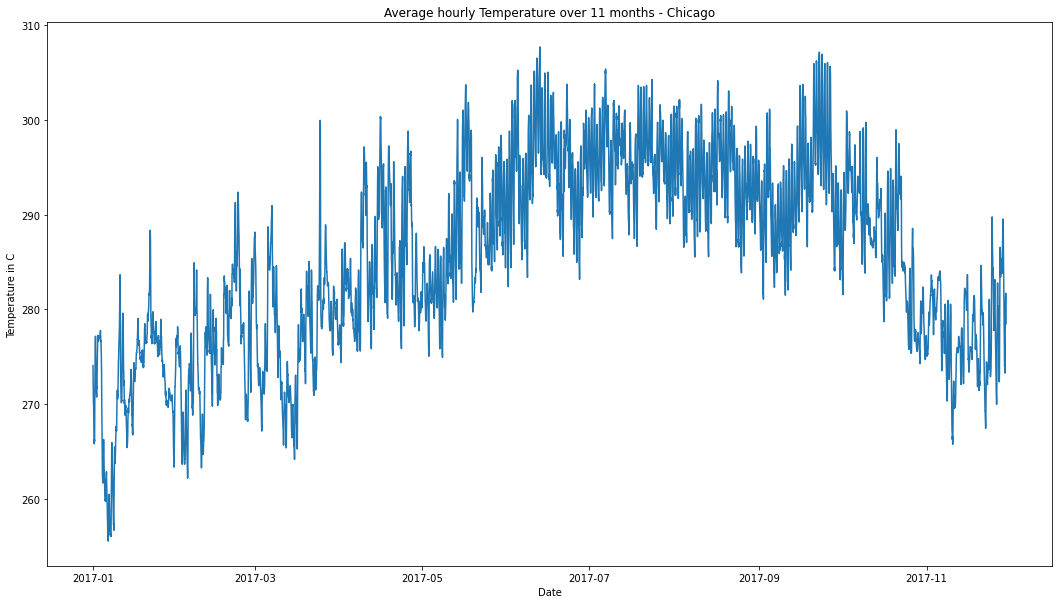

In [141]:
#Convert date value into right datetime format
#temp_chi['DATE']= pd.to_datetime(temp_chi['DATE1'], format='Y-m-d H:M:S')
dateRange_gi = pd.DataFrame({'datetime' : pd.date_range(start='01/01/2017 00:00:00', end='11/30/2017 00:00:00', freq='H')}) 

#Pyplot
plt.figure(figsize = (18,10))
#plt.xticks(np.arange(np.datetime64('2017-01-01'), np.datetime64('2017-11-30'))) 


# plt.plot(temp_chi['DATE'],temp_chi['Temperature'])
plt.plot(dateRange_gi['datetime'],temp_chi['Temperature'])

plt.xlabel('Date')
plt.ylabel('Temperature in C')
plt.title('Average hourly Temperature over 11 months - Chicago')
plt.show()

In [142]:
df['Trip_Min']=df['Trip Seconds']/60

In [143]:
fields = ['datetime', 'Chicago']


hum_chicago1 = pd.read_csv('humidity.csv', skipinitialspace=True, usecols=fields)
hum_chicago = hum_chicago1.rename(columns={'Chicago': 'Humidity'})
hum_chi = hum_chicago[(hum_chicago["datetime"]>='2017-01-01')& (hum_chicago["datetime"]<='2017-12-31')]
hum_chi =hum_chi.reset_index()
hum_chi =hum_chi.drop(['index'], axis=1)
hum_chi

,datetime,Humidity
0,2017-01-01 00:00:00,100.0
1,2017-01-01 01:00:00,50.0
2,2017-01-01 02:00:00,100.0
3,2017-01-01 03:00:00,63.0
4,2017-01-01 04:00:00,73.0
...,...,...
7988,2017-11-29 20:00:00,52.0
7989,2017-11-29 21:00:00,65.0
7990,2017-11-29 22:00:00,96.0
7991,2017-11-29 23:00:00,75.0


In [144]:
fields = ['datetime', 'Chicago']


wind_chicago1 = pd.read_csv('wind_speed.csv', skipinitialspace=True, usecols=fields)
wind_chicago = wind_chicago1.rename(columns={'Chicago': 'Wind_Speed'})
wind_chi = wind_chicago[(wind_chicago["datetime"]>='2017-01-01')& (wind_chicago["datetime"]<='2017-12-31')]
wind_chi =wind_chi.reset_index()
wind_chi =wind_chi.drop(['index'], axis=1)
wind_chi

,datetime,Wind_Speed
0,2017-01-01 00:00:00,4.0
1,2017-01-01 01:00:00,4.0
2,2017-01-01 02:00:00,3.0
3,2017-01-01 03:00:00,3.0
4,2017-01-01 04:00:00,1.0
...,...,...
7988,2017-11-29 20:00:00,2.0
7989,2017-11-29 21:00:00,4.0
7990,2017-11-29 22:00:00,2.0
7991,2017-11-29 23:00:00,2.0


In [145]:
fields = ['datetime', 'Chicago']


des_chicago1 = pd.read_csv('weather_description.csv', skipinitialspace=True, usecols=fields)
des_chicago = des_chicago1.rename(columns={'Chicago': 'Weather_Description'})
des_chi = des_chicago[(des_chicago["datetime"]>='2017-01-01')& (des_chicago["datetime"]<='2017-12-31')]
des_chi =des_chi.reset_index()
des_chi =des_chi.drop(['index'], axis=1)
des_chi

,datetime,Weather_Description
0,2017-01-01 00:00:00,overcast clouds
1,2017-01-01 01:00:00,scattered clouds
2,2017-01-01 02:00:00,sky is clear
3,2017-01-01 03:00:00,sky is clear
4,2017-01-01 04:00:00,sky is clear
...,...,...
7988,2017-11-29 20:00:00,few clouds
7989,2017-11-29 21:00:00,sky is clear
7990,2017-11-29 22:00:00,few clouds
7991,2017-11-29 23:00:00,sky is clear


In [146]:
weather_hourly = temp_chi.merge(hum_chicago, how='left', on='datetime')
weather_hourly1 = weather_hourly.merge(wind_chi, how='left', on='datetime')
weather_hourly2 = weather_hourly1.merge(des_chi, how='left', on='datetime')
weather_hourly2.head()
#https://www.kaggle.com/selfishgene/historical-hourly-weather-data?select=weather_description.csv

,datetime,Temperature,Humidity,Wind_Speed,Weather_Description
0,2017-01-01 00:00:00,274.06,100.0,4.0,overcast clouds
1,2017-01-01 01:00:00,272.94,50.0,4.0,scattered clouds
2,2017-01-01 02:00:00,272.14,100.0,3.0,sky is clear
3,2017-01-01 03:00:00,270.97,63.0,3.0,sky is clear
4,2017-01-01 04:00:00,270.14,73.0,1.0,sky is clear


In [147]:
#df

In [148]:
def weatherday(dft, attribute):
    dateRange_gi = pd.DataFrame({'datetime' : pd.date_range(start='01/01/2017 00:00:00', end='11/30/2017 00:00:00', freq='H')}) 
    Data = {'DATE': dateRange_gi['datetime'],
        attribute: dft[attribute]
       } 
    dft = pd.DataFrame(Data,columns=['DATE',attribute])
    dft['startdtind'] = dft['DATE'].dt.floor('d')
    dft = dft.groupby('startdtind')[attribute].mean()
    #df_day = pd.Series(df['DATE'].resample('1D').mean())
    return dft

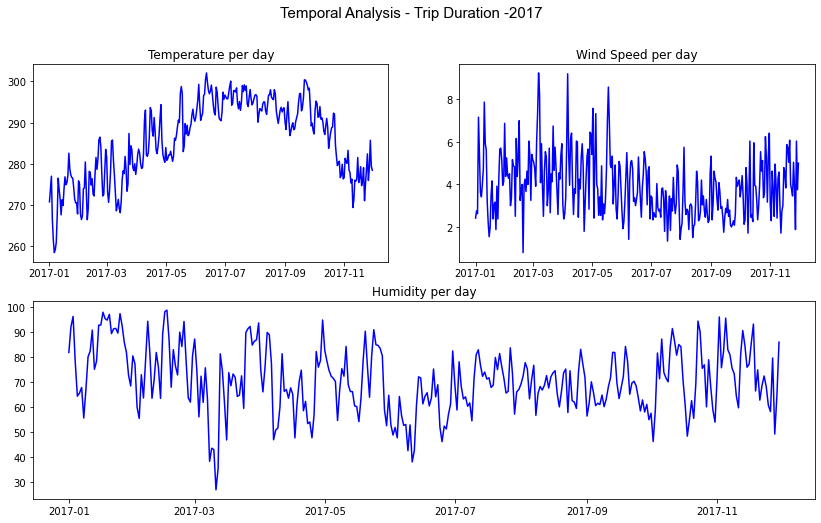

In [149]:
df_day_temp = weatherday(weather_hourly2, 'Temperature')
df_day_wind = weatherday(weather_hourly2, 'Wind_Speed')
df_day_hum = weatherday(weather_hourly2, 'Humidity')

fig,ax=create_gridplot(title="Temporal Analysis - Trip Duration -2017",figsize=(14,8),gridsize=(2,2),plotsizes=[(1,1),(1,1),(1,2)],names=['Temperature per day','Wind Speed per day','Humidity per day'])
ax[0].plot(df_day_temp, color = 'Blue')
ax[1].plot(df_day_wind, color = 'Blue')
ax[2].plot(df_day_hum, color = 'Blue')



In [150]:
df


,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,PU_Centroid,DO_Centroid,PU_isWorkday,DO_isWorkday,PU_hol_date,PU_free,DO_hol_date,DO_free,PU_isWorkday2,Trip_Min
0,5487de4e97b71188efadf95669f532a5ccb08843,56f2fce86600dd132681be1323fe78ce26e60f2fffe4b3...,2017-01-09 11:45:00,2017-01-09 12:00:00,480.0,0.10,NaN,NaN,8.0,7.0,...,POINT (41.89960 41.89960),POINT (41.92269 41.92269),True,True,NaN,NaN,NaN,NaN,True,8.000000
1,491aabe21dbd65e2fa8efca4cdf7d6bf40f45b89,edcd6d939a065b4d0028d5219351a593d77b1b17637db3...,2017-08-17 14:30:00,2017-08-17 14:30:00,240.0,0.90,1.703132e+10,1.703108e+10,32.0,8.0,...,POINT (41.87741 41.87741),POINT (41.89092 41.89092),True,True,NaN,NaN,NaN,NaN,True,4.000000
2,522fe170918a41a9eacb8c665b5a699be9db33c8,fbdfc1bdf8477e6043d2012f98283fdbc6212192a065ab...,2017-03-03 07:30:00,2017-03-03 07:45:00,360.0,0.20,NaN,NaN,6.0,8.0,...,POINT (41.94423 41.94423),POINT (41.89960 41.89960),True,True,NaN,NaN,NaN,NaN,True,6.000000
3,0fc17e1ac2fbdbe5ce772521e712341bb5b19d64,e428b282d868d83ee36a566f79e7e8926c9c3c631809cc...,2017-07-23 10:30:00,2017-07-23 10:30:00,401.0,1.19,1.703132e+10,1.703108e+10,32.0,8.0,...,POINT (41.88499 41.88499),POINT (41.89197 41.89197),False,False,NaN,NaN,NaN,NaN,False,6.683333
4,53278beb03b150357771f184b6b0787eec16c095,5e3077a68e0439a1168a98d848e9ae3fd8c74f61bc4323...,2017-02-25 10:00:00,2017-02-25 10:30:00,1496.0,17.50,1.703198e+10,1.703108e+10,76.0,8.0,...,POINT (41.97907 41.97907),POINT (41.89092 41.89092),True,True,NaN,NaN,NaN,NaN,True,24.933333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,040c6f5bf932d7935bec7f8377b67a368fa6e683,2696ea0536d336d599581f7b3328fb73e9d0084a73e680...,2017-04-12 12:45:00,2017-04-12 13:00:00,420.0,1.10,1.703184e+10,1.703183e+10,32.0,28.0,...,POINT (41.88099 41.88099),POINT (41.88528 41.88528),True,True,NaN,NaN,NaN,NaN,True,7.000000
99996,347c667c8e7a003fd9b46e0b2de67e7db8d52723,9ca885399cc8b816626c963092acd6676ff75f7700d5cf...,2017-10-22 11:15:00,2017-10-22 12:00:00,2100.0,0.80,1.703103e+10,1.703198e+10,77.0,76.0,...,POINT (41.97991 41.97991),POINT (41.97907 41.97907),False,False,NaN,NaN,NaN,NaN,False,35.000000
99997,6ba317d98f0d731fee139aa276bdf9f1b8402afc,0f3f29ac05b3574275f73ea36e2e0ff7ca74e41c8e72d1...,2017-09-18 11:00:00,2017-09-18 11:15:00,420.0,1.00,1.703108e+10,1.703132e+10,8.0,32.0,...,POINT (41.89503 41.89503),POINT (41.88499 41.88499),True,True,NaN,NaN,NaN,NaN,True,7.000000
99998,78048884f01e25c094e35ecdc9453b37569ed9b6,21e2b3e333e8fd4e230f6ac671b772a39531c2b3d57e66...,2017-06-23 14:00:00,2017-06-23 14:15:00,420.0,1.20,1.703128e+10,1.703108e+10,28.0,8.0,...,POINT (41.88530 41.88530),POINT (41.89092 41.89092),True,True,NaN,NaN,NaN,NaN,True,7.000000


## Descriptive Analysis - Temporal (not final)

In [151]:
df['Date'] = pd.to_datetime(df['Trip Start Timestamp'], format='%m/%d/%Y %I:%M:%S %p')
df.index = df.Date
df_weekPerYear = pd.Series(df['Date'].resample('1W').count())

In [152]:
df_weekPerYear

Date
2017-01-01     261
2017-01-08    1726
2017-01-15    2042
2017-01-22    1952
2017-01-29    1905
2017-02-05    1942
2017-02-12    2077
2017-02-19    2091
2017-02-26    2090
2017-03-05    2183
2017-03-12    2240
2017-03-19    2426
2017-03-26    2220
2017-04-02    2166
2017-04-09    2302
2017-04-16    2093
2017-04-23    2209
2017-04-30    2103
2017-05-07    2339
2017-05-14    2317
2017-05-21    2358
2017-05-28    2185
2017-06-04    2242
2017-06-11    2431
2017-06-18    2428
2017-06-25    2241
2017-07-02    2109
2017-07-09    1683
2017-07-16    2109
2017-07-23    2145
2017-07-30    2023
2017-08-06    2181
2017-08-13    2003
2017-08-20    2208
2017-08-27    1903
2017-09-03    1878
2017-09-10    1864
2017-09-17    2211
2017-09-24    2027
2017-10-01    1927
2017-10-08    2166
2017-10-15    2149
2017-10-22    2221
2017-10-29    2030
2017-11-05    1937
2017-11-12    2055
2017-11-19    2058
2017-11-26    1356
2017-12-03    1188
Freq: W-SUN, Name: Date, dtype: int64

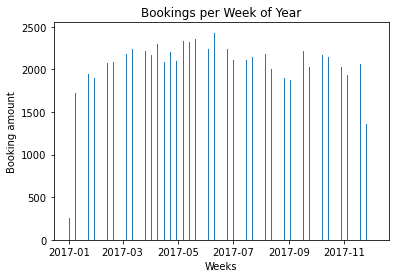

In [153]:
import matplotlib.pyplot as plt

plt.bar(df_weekPerYear.index,df_weekPerYear)
plt.xlabel('Weeks')
plt.ylabel('Booking amount')
plt.title('Bookings per Week of Year')
plt.show()

In [154]:
df_monthly = pd.Series(df['Date'].resample('1M').count())


In [155]:
df['start_month'] = df['Trip Start Timestamp'].dt.month
df['end_month'] = df['Trip End Timestamp'].dt.month
df['startdtinh'] = df['Trip Start Timestamp'].dt.floor('d')
df['enddtinh'] = df['Trip End Timestamp'].dt.floor('d')

In [156]:
df22= df.groupby('start_month')['Trip Seconds']
df33= df.groupby('end_month')['Trip Seconds']

In [157]:
df22.head()

Date
2017-01-09 11:45:00     480.0
2017-08-17 14:30:00     240.0
2017-03-03 07:30:00     360.0
2017-07-23 10:30:00     401.0
2017-02-25 10:00:00    1496.0
2017-09-26 19:15:00     456.0
2017-04-11 14:15:00     305.0
2017-02-24 19:45:00     180.0
2017-10-12 21:45:00    1740.0
2017-08-05 19:15:00     660.0
2017-05-21 00:15:00     480.0
2017-04-06 18:15:00     720.0
2017-09-13 16:30:00     686.0
2017-01-30 15:00:00    2100.0
2017-02-13 14:45:00     420.0
2017-07-03 17:45:00    1080.0
2017-06-01 15:45:00    2160.0
2017-01-02 09:30:00     539.0
2017-02-14 09:45:00     180.0
2017-03-29 19:00:00     660.0
2017-11-17 19:15:00     542.0
2017-06-08 14:00:00     633.0
2017-06-28 20:30:00     420.0
2017-07-30 21:30:00     480.0
2017-10-15 17:00:00     840.0
2017-06-16 17:15:00     579.0
2017-06-08 12:00:00     360.0
2017-03-16 07:30:00     180.0
2017-05-10 14:45:00     180.0
2017-03-10 21:00:00     180.0
2017-04-08 00:15:00    1080.0
2017-08-04 18:00:00     960.0
2017-04-24 09:45:00    1440.0
2017-

In [158]:
df_monthly

Date
2017-01-31     8401
2017-02-28     8239
2017-03-31    10143
2017-04-30     9245
2017-05-31     9948
2017-06-30    10151
2017-07-31     8777
2017-08-31     9150
2017-09-30     8555
2017-10-31     9260
2017-11-30     8131
Freq: M, Name: Date, dtype: int64

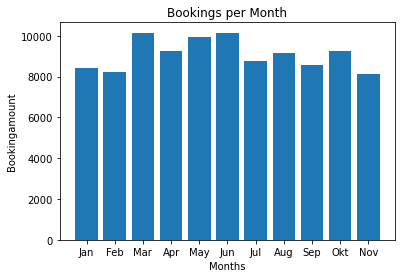

In [159]:
months =['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov' ]
plt.bar(months,df_monthly) #Karlsruhe
plt.xlabel('Months')
plt.ylabel('Bookingamount')
plt.title('Bookings per Month')
plt.show()

In [160]:
#check this and the method before
week = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

#array that will get filled in in the following
df_weekday = []

#add weekday to bike_set of Karlsruhe
for weekday in range(0,7):
    df_weekday.append([weekday,df['Date'].loc[(df['Date'].dt.dayofweek) == weekday].count()])
df_weekday = pd.DataFrame(df_weekday)



In [161]:
df_weekday

,0,1
0,0,12860
1,1,14397
2,2,15620
3,3,16393
4,4,16336
5,5,13261
6,6,11133


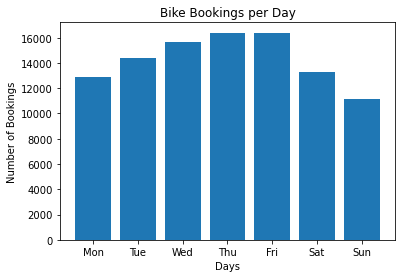

In [162]:
# Chart day of week data
plt.bar(week,df_weekday[1])

# Labeling
plt.xlabel('Days')
plt.ylabel('Number of Bookings')
plt.title('Bike Bookings per Day')
plt.show()

In [163]:
dayhour = []

# Determine the amount of hourly trips
for hour in range(0,24):
    dayhour.append([hour,df['Date'].loc[(df['Date'].dt.hour) == hour].count()])
dayhour = pd.DataFrame(dayhour)


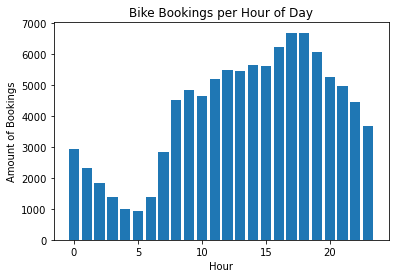

In [164]:
# Bar chart the hour of day data and give labels
plt.bar(dayhour[0], dayhour[1])
plt.xlabel('Hour')
plt.ylabel('Amount of Bookings')
plt.title('Bike Bookings per Hour of Day')
plt.show()

## Comparison of Work and Free Day

### Analysis of Trip Number

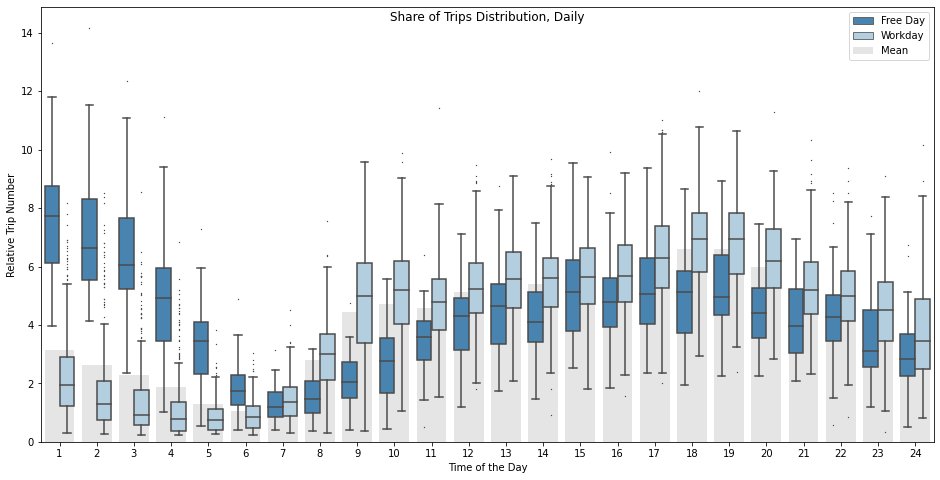

In [165]:
fig,ax = plt.subplots(1, 1, figsize=(16, 8))

color_palette = "Blues_r"
boxplot = sns.boxplot(ax = ax,
                 data=df_hourly, 
                 x="HOUR", 
                 y="relative_trips", 
                 hue='workday', 
                 palette=color_palette,
                 zorder = 1,
                     fliersize=0.5)


df_hourly_avg = df_hourly.groupby("HOUR").agg(avg = ("relative_trips","mean"))
avg = sns.barplot(x=df_hourly_avg.index,
                   y=df_hourly_avg.avg,
                   zorder = 0,
                   ax = ax,
                   color="black",
                   linewidth=20,
                   alpha = 0.1,
                 label = "average")

handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["Free Day", "Workday","Mean"], loc="best")


_=ax.set_title("Share of Trips Distribution, Daily",y=1.0, pad=-14)
_=ax.set_ylabel('Relative Trip Number')
_=ax.set_xlabel('Time of the Day')

### Analysis of Trip Duration

<AxesSubplot:title={'center':'Stacked Bar Graph'}, ylabel='month'>

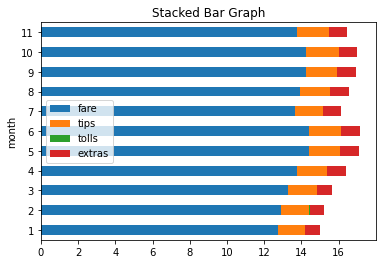

In [166]:
# total = []
# for i in range(len(dff)):
#     n = dff['']
#     dates.append(n)

dfc =  df[["Fare", "Tips","Tolls", "Extras"]]

avgfare = df.groupby('start_month')['Fare'].mean()
avgtips = df.groupby('start_month')['Tips'].mean()
avgtolls = df.groupby('start_month')['Tolls'].mean()
avgextras = df.groupby('start_month')['Extras'].mean()
months =avgfare.index

# totalperc1 = avgfare.merge(avgtips, how='left', on='start_month')
# totalperc2 = totalperc1.merge(avgtolls, how='left', on='start_month')
# totalperc = totalperc2.merge(avgextras, how='left', on='start_month')


Data = {'month': months,
        'fare': avgfare,
        'tips': avgtips,
        'tolls': avgtolls,
        'extras': avgextras
       }

dfcc = pd.DataFrame(Data,columns=['month','fare','tips','tolls','extras'])
dfcc
#figure size
dfcc.plot(
    x = 'month',
    kind = 'barh',
    stacked = True,
    title = 'Stacked Bar Graph',
    mark_right = True)



## Trip Duration along 1 hour Buckets and 4 hour buckets


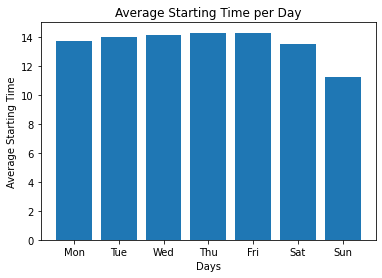

In [167]:
#check this and the method before
week = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

#array that will get filled in in the following
df_weekday = []

#['Trip Start Timestamp']
#df.groupby(df["'Trip Start Timestamp'"].dt.hour)["value"].mean().plot(
#add weekday to bike_set of Karlsruhe
for weekday in range(0,7):
    df_weekday.append([weekday,df['Trip Start Timestamp'].loc[(df['Date'].dt.dayofweek) == weekday].dt.hour.mean()])
df_weekday = pd.DataFrame(df_weekday)

df_weekday

Data = {'DATE': week,
        'Starttime': df_weekday[1]
       } 
avgdstarttimedayoftheweek = pd.DataFrame(Data,columns=['DATE','Starttime'])

# Chart day of week data
#eher plot
plt.bar(week,df_weekday[1])

# Labeling, check
plt.xlabel('Days')
plt.ylabel('Average Starting Time')
plt.title('Average Starting Time per Day')
plt.show()

In [168]:
#air_quality.groupby(air_quality["datetime"].dt.hour)["value"].mean().plot(

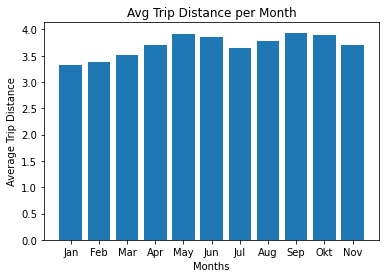

In [169]:
avgdistance = df.groupby('start_month')['Trip Miles'].mean()
avgdistance


months =['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov' ]

Data = {'DATE': months,
        'Duration': avgdistance
       } 
avgdistancedayoftheweek = pd.DataFrame(Data,columns=['DATE','Distance'])

plt.bar(months,avgdistance) 
plt.xlabel('Months')
plt.ylabel('Average Trip Distance')
plt.title('Avg Trip Distance per Month')
plt.show()

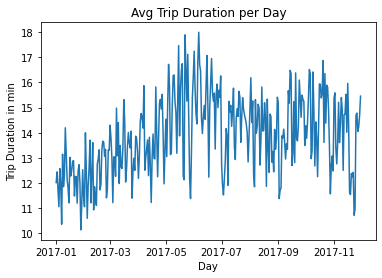

In [170]:
avgdurationday = df.groupby('startdtinh')['Trip_Min'].mean()
#months =['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov' ]
plt.plot(avgdurationday) 
plt.xlabel('Day')
plt.ylabel('Trip Duration in min')
plt.title('Avg Trip Duration per Day')
plt.show()

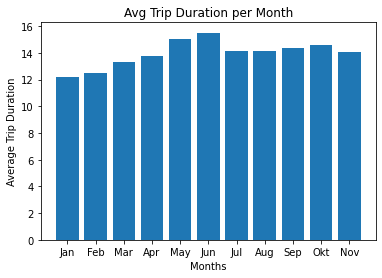

In [171]:
avgduration = df.groupby('start_month')['Trip_Min'].mean()
#avgdistance


months =['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov' ]

Data = {'DATE': months,
        'Duration': avgduration
       } 
avgdurationmonth = pd.DataFrame(Data,columns=['DATE','Duration'])
plt.bar(months,avgduration) 
plt.xlabel('Months')
plt.ylabel('Average Trip Duration')
plt.title('Avg Trip Duration per Month')
plt.show()

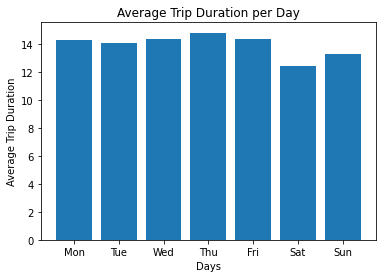

In [172]:
#check this and the method before
week = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

#array that will get filled in in the following
df_weekday = []

#['Trip Start Timestamp']
#df.groupby(df["'Trip Start Timestamp'"].dt.hour)["value"].mean().plot(
#add weekday to bike_set of Karlsruhe
for weekday in range(0,7):
    df_weekday.append([weekday,df['Trip_Min'].loc[(df['Date'].dt.dayofweek) == weekday].mean()])
df_weekday = pd.DataFrame(df_weekday)

df_weekday

Data = {'DATE': week,
        'Duration': df_weekday[1]
       } 
avgdurationdayoftheweek = pd.DataFrame(Data,columns=['DATE','Duration'])

# Chart day of week data
#eher plot
plt.bar(week,df_weekday[1])

# Labeling, check
plt.xlabel('Days')
plt.ylabel('Average Trip Duration')
plt.title('Average Trip Duration per Day')
plt.show()

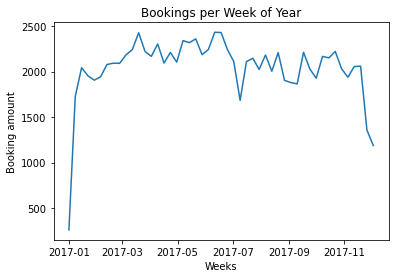

In [173]:
#df['Date'] = pd.to_datetime(df['Trip Start Timestamp'], format='%m/%d/%Y %I:%M:%S %p')
#df.index = df.Date
avgdurationweek = pd.Series(df['Trip_Min'].resample('1W').mean())
plt.plot(df_weekPerYear.index,df_weekPerYear)
plt.xlabel('Weeks')
plt.ylabel('Booking amount')
plt.title('Bookings per Week of Year')
plt.show()

In [174]:

def plottemporal(df1,df2,df3,df4, title):
    fig = plt.figure(figsize=(18,10))
    fig.suptitle(title,fontsize=23)

    gs = fig.add_gridspec(2,2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])

    ax1.plot(df1, color = 'Blue')
    ax1.set_title('x per day', color = "Blue")
    ax2.plot(df2, color = 'Blue')
    ax2.set_title('x per week', color = "Blue")
    ax3.bar(df3.DATE, df3.Duration, color = 'Blue')
    ax3.set_title('x per month', color = "Blue")
    ax4.bar(df4.DATE, df4.Duration, color = 'Blue')
    ax4.set_title('x day of the week', color = "Blue")

    plt.show()
    
    

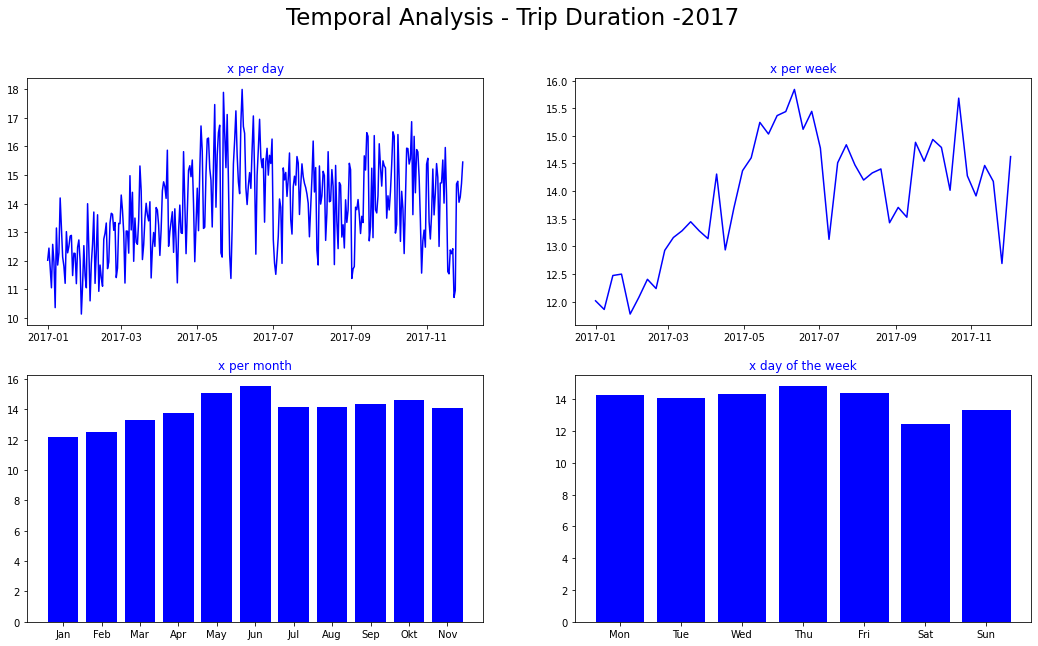

In [189]:
plottemporal(avgdurationday,avgdurationweek,avgdurationmonth,avgdurationdayoftheweek, 'Temporal Analysis - Trip Duration -2017')
#create_gridplot(title="Temporal Analysis - Trip Duration -2017",figsize=(18,10),gridsize=(2,2),plotsizes=[(1,1),(1,1),(1,1)],direction="h",names=[])

In [190]:
#to be edited
#plottemporal(avgdurationday,avgdurationweek,avgdurationmonth,avgdurationdayoftheweek, 'Temporal Analysis - Starting Time -2017')

In [177]:
df_trips_per_day = pd.Series(df['Date'].resample('1D').count())
df_trips_per_day

Date
2017-01-01    261
2017-01-02    129
2017-01-03    217
2017-01-04    258
2017-01-05    339
             ... 
2017-11-26    188
2017-11-27    276
2017-11-28    312
2017-11-29    284
2017-11-30    316
Freq: D, Name: Date, Length: 334, dtype: int64

In [178]:
df_day_temp

startdtind
2017-01-01    270.790000
2017-01-02    274.022083
2017-01-03    277.005833
2017-01-04    266.399167
2017-01-05    261.437083
                 ...    
2017-11-26    275.980833
2017-11-27    279.128333
2017-11-28    285.730833
2017-11-29    279.479583
2017-11-30    278.460000
Name: Temperature, Length: 334, dtype: float64

In [179]:
df_trips_per_day

Date
2017-01-01    261
2017-01-02    129
2017-01-03    217
2017-01-04    258
2017-01-05    339
             ... 
2017-11-26    188
2017-11-27    276
2017-11-28    312
2017-11-29    284
2017-11-30    316
Freq: D, Name: Date, Length: 334, dtype: int64

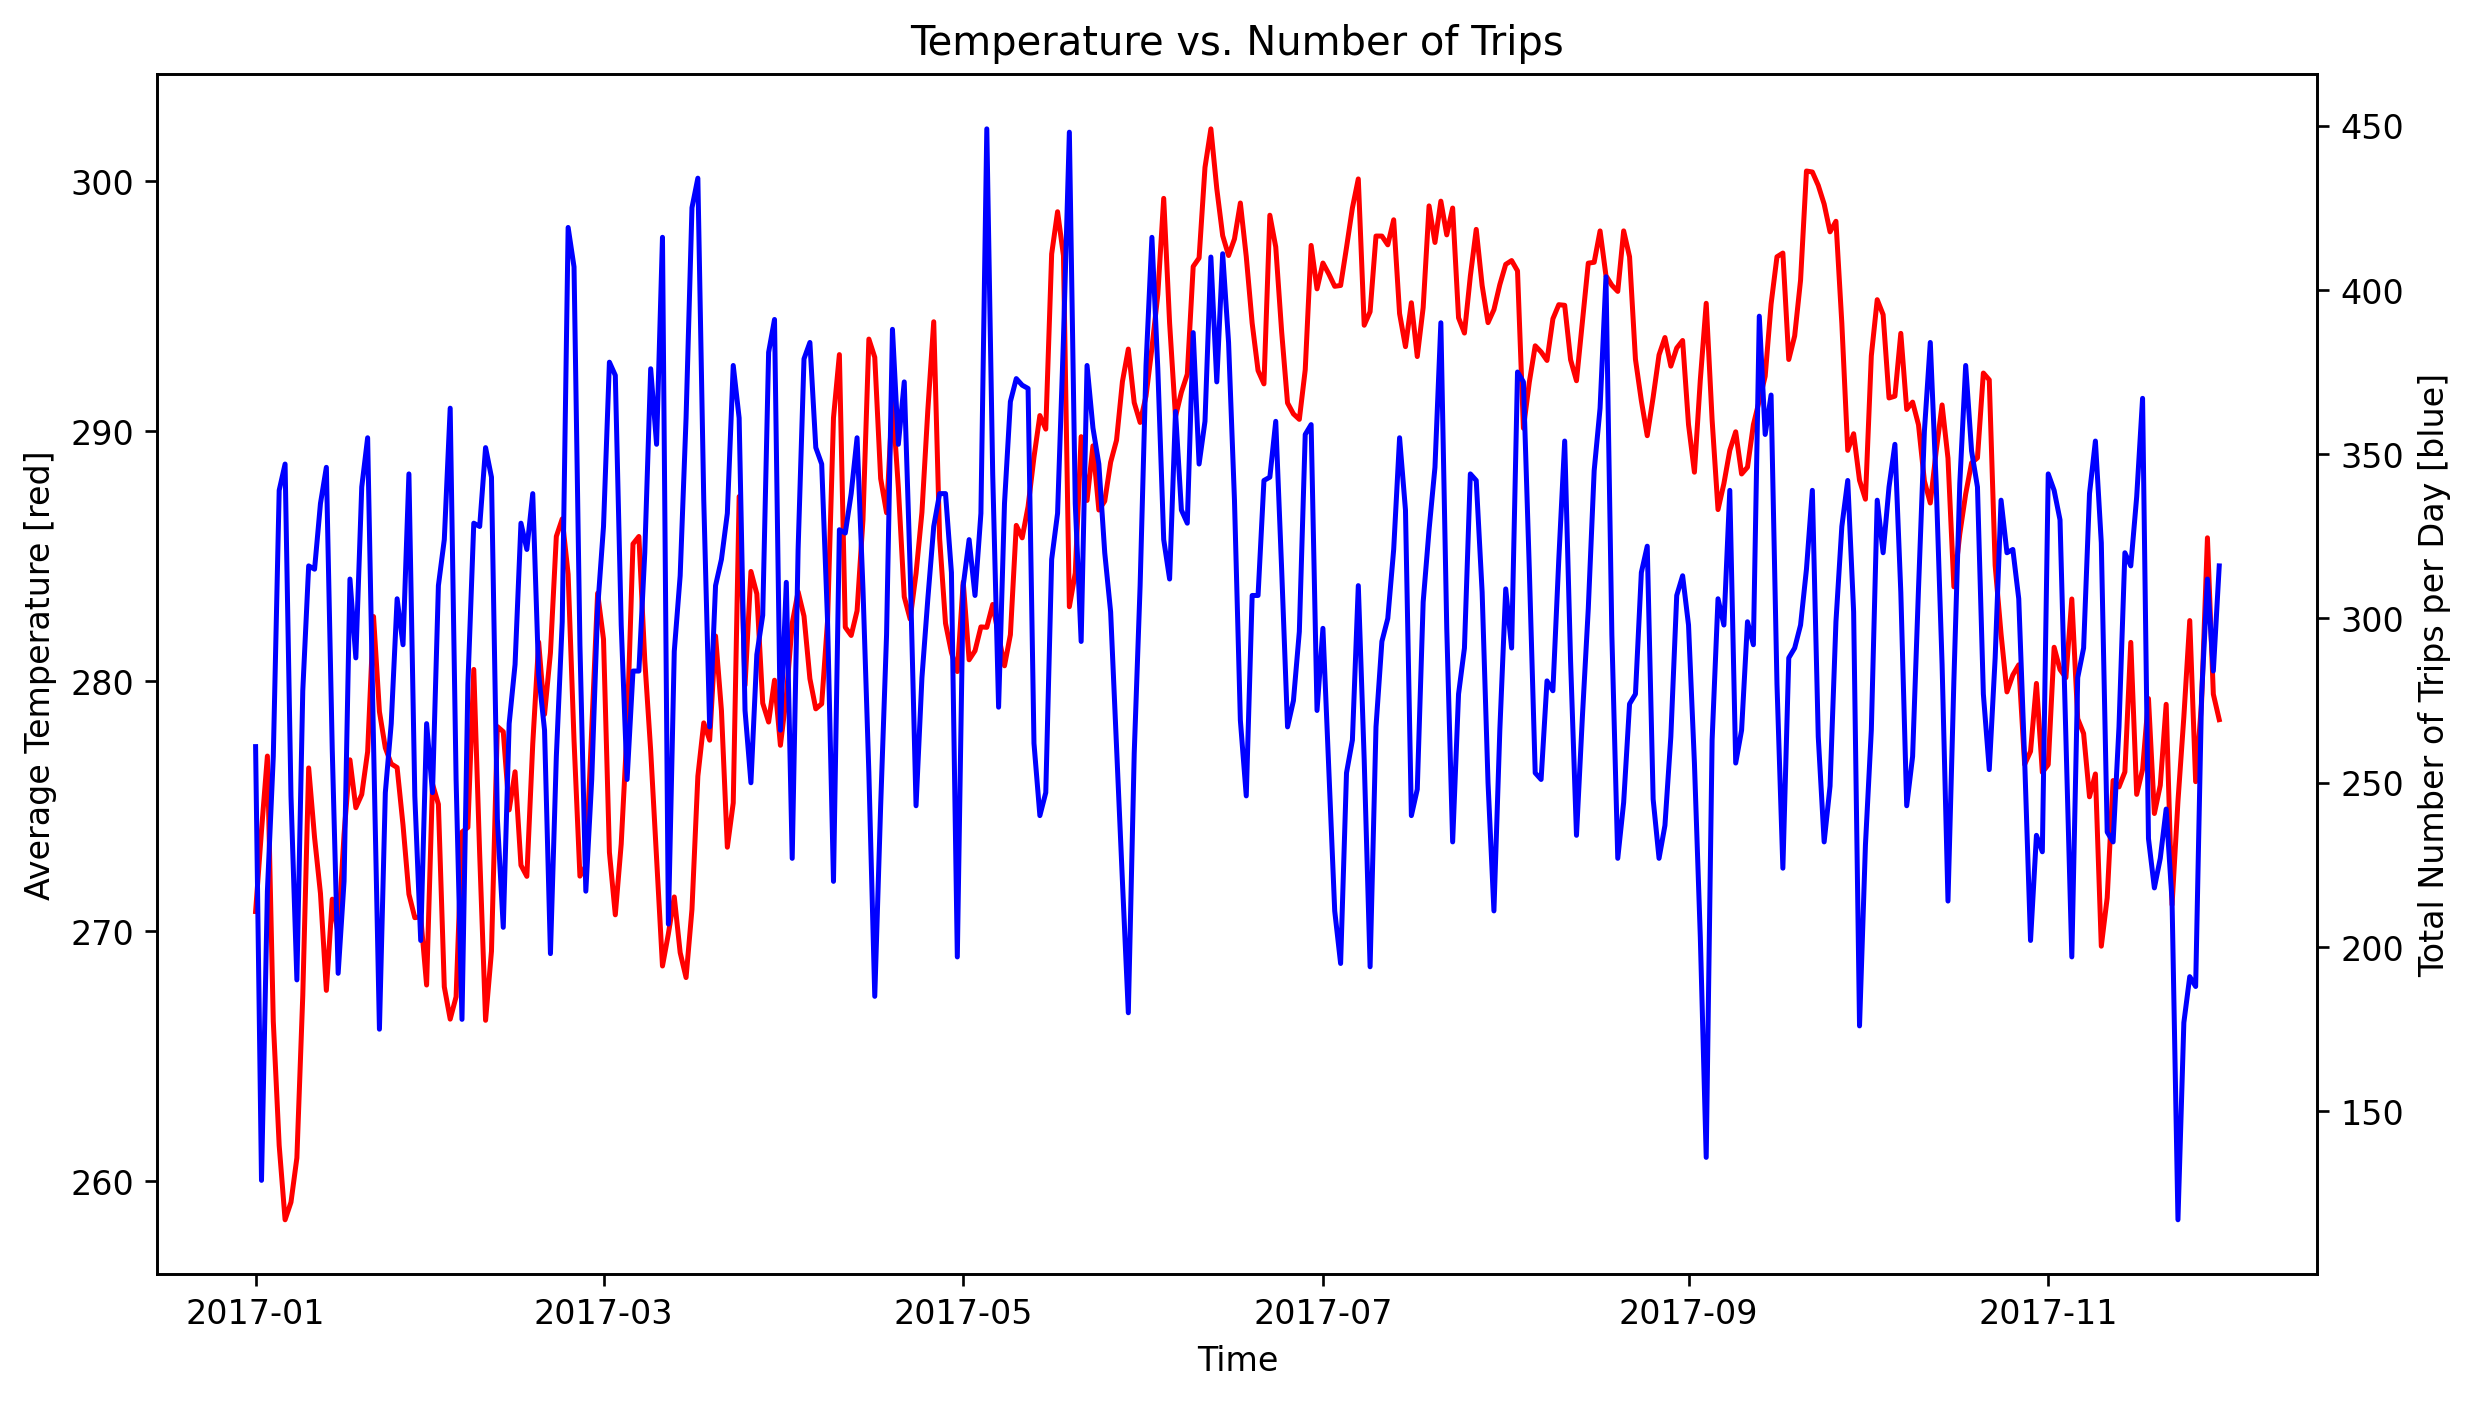

In [180]:
df_trips_per_day = pd.Series(df['Date'].resample('1D').count())

#Plot 
Fig = plt.figure(figsize=(18,10),dpi = 240)
ax1 = Fig.add_axes([0,0,0.5,0.5])
ax1.set_ylabel('Average Temperature [red]', color='Black')
ax1.set_xlabel('Time')
ax1.set_title('Temperature vs. Number of Trips', color='Black')
ax1.plot(df_day_temp, color = 'Red')

ax2 = ax1.twinx() 
ax2.set_ylabel('Total Number of Trips per Day [blue]', color='Black')
ax2.plot(df_trips_per_day, color = 'Blue')

plt.show()

#Save image
#Fig.savefig("Images/TempforStartTime_kassel.png", bbox_inches='tight')


## Descriptive Analysis - Geographic

### Get H3 Resolution in Data

In [181]:
h3_resolution = h3.h3_get_resolution(df["PU_H3"].iloc[0])
h3_resolution

8

### Build H3 Grid

In [182]:
chicago_fence = gpd.read_file("../data/chicago.geojson")
chicago_boundary_pol = chicago_fence.geometry[0][1]
poly_geojson = gpd.GeoSeries([chicago_boundary_pol]).__geo_interface__
# Parse out geometry key from GeoJSON dictionary
poly_geojson = poly_geojson['features'][0]['geometry'] 

# Create an empty dataframe to write data into
h3_df = pd.DataFrame([],columns=['h3_id','h3_geo_boundary','h3_centroid'])

# Fill the dictionary with H3 Hexagons
h3_hexes = h3.polyfill_geojson(poly_geojson, h3_resolution)

for h3_hex in h3_hexes:
    h3_geo_boundary = shapely.geometry.Polygon(
        h3.h3_to_geo_boundary(h3_hex,geo_json=True))
    h3_centroid = h3.h3_to_geo(h3_hex)
    h3_df.loc[len(h3_df)]=[
        h3_hex,
        h3_geo_boundary,
        h3_centroid
        ]
h3_gdf = gpd.GeoDataFrame(h3_df,geometry="h3_geo_boundary")

In [183]:
h3_gdf

,h3_id,h3_geo_boundary,h3_centroid
0,882664cea1fffff,"POLYGON ((-87.56812 41.77470, -87.57415 41.772...","(41.770056747576966, -87.56877558720699)"
1,882664cea5fffff,"POLYGON ((-87.57953 41.77575, -87.58556 41.773...","(41.771104545320064, -87.58017965184062)"
2,88275935dbfffff,"POLYGON ((-87.91756 41.96867, -87.92359 41.966...","(41.96400996656684, -87.91817974193624)"
3,882664d9a7fffff,"POLYGON ((-87.78781 41.98539, -87.79385 41.983...","(41.98073699001463, -87.78844226708055)"
4,882664d813fffff,"POLYGON ((-87.67891 42.01804, -87.68496 42.016...","(42.01337849154939, -87.67955322700874)"
...,...,...,...
804,882664cd3bfffff,"POLYGON ((-87.69551 41.77223, -87.70153 41.770...","(41.76758264081917, -87.69615240206049)"
805,8826641965fffff,"POLYGON ((-87.58458 41.69861, -87.59060 41.696...","(41.69396696452814, -87.58522980317636)"
806,882664cf67fffff,"POLYGON ((-87.67922 41.84840, -87.68525 41.846...","(41.84374690434265, -87.6798593125506)"
807,88266452d3fffff,"POLYGON ((-87.71075 41.74539, -87.71677 41.743...","(41.74075056808289, -87.71138759108185)"


### Group to H3 Slices

In [184]:
def group_slice(df,hour_feature_name,feature_name,slices):
    df_grouped = df.copy()
    divider = 24/slices
    df_grouped["hour_slice"] = np.floor(df_grouped[hour_feature_name] / divider).astype(int)
    df_grouped = df_grouped.groupby(["hour_slice",feature_name]).agg(count=(feature_name,"count"),
                                                                       avgduration=("Trip Seconds","mean"))
    df_grouped["H3"] = df_grouped.index.get_level_values(1)
    df_grouped["geometry"] = df_grouped.apply(lambda x: hex_to_geoboundary(x["H3"]),axis=1)
    df_grouped["hour_slice"] = df_grouped.index.get_level_values(0)
    return gpd.GeoDataFrame(df_grouped, geometry='geometry')

gdf_sliced_pu = group_slice(df,"PU_HOUR","PU_H3",4)
gdf_sliced_do = group_slice(df,"DO_HOUR","DO_H3",4)

In [185]:
gdf_sliced_pu.sample(10)

count  avgduration               H3  \
hour_slice PU_H3                                                  
3          882664cf01fffff     15   949.333333  882664cf01fffff   
2          882664c1a3fffff     41   445.390244  882664c1a3fffff   
1          882664cac7fffff      1  1063.000000  882664cac7fffff   
2          882664cad1fffff     21   701.809524  882664cad1fffff   
           882664c1b1fffff    756   975.829365  882664c1b1fffff   
           8827593433fffff    690  1995.239130  8827593433fffff   
           882664c123fffff      2  1193.000000  882664c123fffff   
           882664ca9dfffff     21   847.571429  882664ca9dfffff   
4          882664c161fffff     41   834.000000  882664c161fffff   
           882664d8bdfffff     20   528.050000  882664d8bdfffff   

                                                                     geometry  \
hour_slice PU_H3                                                                
3          882664cf01fffff  POLYGON ((-87.65163 41.83883, -87.65766 41.837...   
2          882664c1a3fffff  POLYGON ((-87.62964 41.87214, -87.63568 41.870...   
1          882664cac7fffff  POLYGON ((-87.68293 41.90525, -87.68897 41.903...   
2          882664cad1fffff  POLYGON ((-87.65530 41.89568, -87.66134 41.893...   
           882664c1b1fffff  POLYGON ((-87.61347 41.86360, -87.61951 41.861...   
           8827593433fffff  POLYGON ((-87.91570 41.98264, -87.92174 41.980...   
           882664c123fffff  POLYGON ((-87.66287 41.92464, -87.66891 41.922...   
           882664ca9dfffff  POLYGON ((-87.66867 41.88276, -87.67471 41.880...   
4          882664c161fffff  POLYGON ((-87.65899 41.95257, -87.66504 41.950...   
           882664d8bdfffff  POLYGON ((-87.68471 41.97611, -87.69076 41.974...   

                            hour_slice  
hour_slice PU_H3                        
3          882664cf01fffff           3  
2          882664c1a3fffff           2  
1          882664cac7fffff           1  
2          882664cad1fffff           2  
           882664c1b1fffff           2  
           8827593433fffff           2  
           882664c123fffff           2  
           882664ca9dfffff           2  
4          882664c161fffff           4  
           882664d8bdfffff           4

### Plot Sliced Heatmap

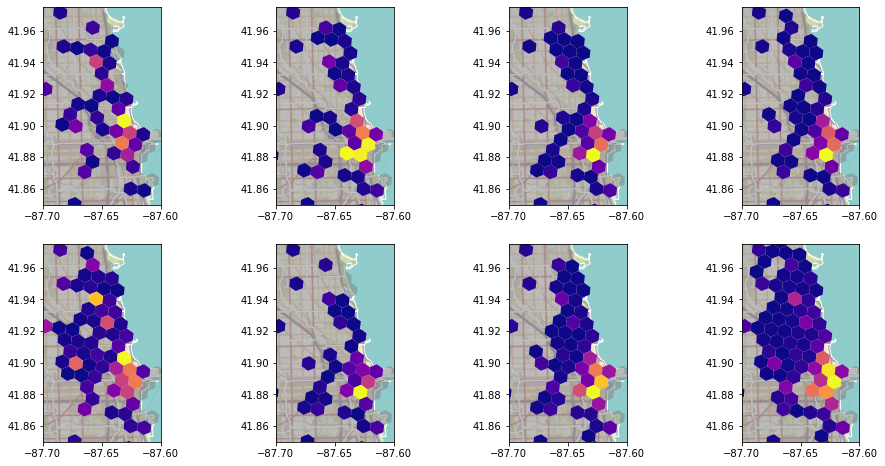

In [186]:
def plot_chicago_heatmap(df,ax,h3_column,feature_column,h3_gdf,filter_value=0,cmap="plasma"):
    data = df[[h3_column,feature_column]]
    data = pd.merge(h3_gdf,data,how="left",left_on="h3_id",right_on=h3_column)
    data[feature_column] = data[feature_column].fillna(0)
    data_below = data[data[feature_column]<=filter_value]
    data_above = data[data[feature_column]>filter_value]
    
    
    chicago_fence.plot(ax=ax,edgecolor="white",color="none")
    data_below.plot(ax=ax,color="grey",alpha=0.5,edgecolor="none")
    plot = data_above.plot(ax=ax,column=feature_column,cmap=cmap)
    ctx.add_basemap(ax=ax,zoom=12,crs=4326,source='https://a.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png')
    chicago_fence.plot(ax=ax,alpha=0) #das macht nur die skalierung richtig
    ax.set_xlim(-87.7,-87.6)
    ax.set_ylim(41.85,41.975)
    
    return plot

fig,axes = plt.subplots(2,4,figsize = (16,8))

chicago_fence = gpd.read_file("../data/chicago-community-areas.geojson")


i = 0
for ax in axes[0]:
    plot_df = gdf_sliced_pu[gdf_sliced_pu["hour_slice"]==i]
    plot = plot_chicago_heatmap(plot_df,ax,"H3","count",h3_gdf,10)
    i=i+1
    
i = 0
for ax in axes[1]:
    plot_df = gdf_sliced_do[gdf_sliced_do["hour_slice"]==i]
    plot = plot_chicago_heatmap(plot_df,ax,"H3","count",h3_gdf,10)
    i=i+1

In [187]:
df_grouped_pu = df.groupby("PU_H3").agg(avgduration=("Trip Seconds","mean"),
                                        avgdistance=("Trip Miles","mean"),
                                        avgpay=("Trip Total","mean"),
                                        count=("Trip Total","count"),
                                        revenue=("Trip Total","sum"),
                                        H3=("PU_H3","min")
)
df_grouped_pu

,avgduration,avgdistance,avgpay,count,revenue,H3
PU_H3,,,,,,
8826641961fffff,864.416667,3.210833,13.716667,12,164.60,8826641961fffff
8826641b23fffff,2879.000000,21.200000,56.000000,1,56.00,8826641b23fffff
882664520bfffff,1624.460550,10.466147,40.317284,545,21972.92,882664520bfffff
8826645215fffff,2374.250000,9.175000,32.955000,4,131.82,8826645215fffff
8826645219fffff,1864.976419,11.386802,44.127119,1357,59880.50,8826645219fffff
...,...,...,...,...,...,...
88275934cdfffff,1587.000000,11.500000,37.400000,2,74.80,88275934cdfffff
88275934edfffff,2286.860879,14.641400,53.035379,4780,253509.11,88275934edfffff
8827593699fffff,993.476923,5.270769,20.686462,65,1344.62,8827593699fffff


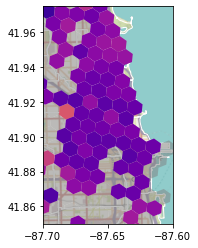

In [188]:
#plot_df = gdf_sliced_pu[gdf_sliced_pu["hour_slice"]==i]
    #chicago_fence.plot(ax=ax,edgecolor="white",color="none")
fig,ax = plt.subplots()
#ax.set_xlim(-90,-87.6)
#ax.set_ylim(41.85,41.975)
plot = plot_chicago_heatmap(df_grouped_pu,ax,"H3","avgduration",h3_gdf,10)
    #ctx.add_basemap(ax=ax,zoom=12,crs=4326,source='https://a.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png')
    #chicago_fence.plot(ax=ax,alpha=0) #das macht nur die skalierung richtig
    
    ##ax.axis('off')
    #i=i+1

## Write results in parquet file 